In [1]:
%load_ext autoreload
%autoreload 1
%aimport my

import sys
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
# import seaborn as sns

import my
from my import p

pd.set_option('display.max_rows', 200)
pd.set_option("max_colwidth", 45)
pd.set_option("display.precision", 1)
pd.options.display.float_format = "{:.3f}".format
# pd.set_option("display.max_rows", 5)
# pd.reset_option("display.max_rows")

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
     
 # номер или название эксперимента
# n_exp = '1/'
dir_out = "out/"
dir_data = 'data/'
my.dir_data = dir_data
os.makedirs(dir_out, exist_ok = True)

RANDOM_STATE = 34
np.random.seed(RANDOM_STATE)
N_CPU = os.cpu_count()

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
df = pd.read_csv(dir_data+'train_transactions_extended.csv',sep=';',parse_dates=['date_1'])
df.sort_values(['chb','date_1'],inplace=True)
df.drop_duplicates(subset=['chb','sys_numb'],keep='last',inplace=True)

df['time_inv_rank'] = df.groupby('chb')['date_1'].rank(method='first',ascending=False)

df = df[df['time_inv_rank']<500]

p(df.shape)
df[:5]

(212877, 8)


,chb,sys_numb,date_1,is_real,type,source,is_printed,time_inv_rank
0,100000641403,RSL01004206702,2021-02-21,yes,скачивание,dlib.rsl.ru,False,2.000
2,100000641403,RSL01004211574,2021-02-21,yes,скачивание,dlib.rsl.ru,False,3.000
1,100000641403,RSL01000769304,2021-03-23,yes,скачивание,dlib.rsl.ru,False,1.000
13,100000644359,RSL01010594911,2021-03-09,yes,книговыдача,единый просмоторщик,False,11.000
4,100000644359,RSL01003557352,2021-03-10,yes,книговыдача,единый просмоторщик,False,7.000


In [2]:
us = pd.read_csv(dir_data+'users.csv',sep=';')
p(us.shape)
us = my.prepro_users(us)
us[:3]

(16753, 4)


,chb,age,gender,chit_type,ff_age,ff_gender,ff_chit_type
0,300001020830,21,f,no,f1:17,f2:f,f3:no
1,300001113642,36,f,no,f1:30,f2:f,f3:no
2,300001148466,46,f,no,f1:40,f2:f,f3:no


In [7]:
it = pd.read_csv(dir_data+'items.csv',sep=';').drop(columns='bbk')
p(it.shape)
it[:3]

(354355, 5)


,sys_numb,title,author,izd,year_izd
0,RSL01008600016,Судебное следствие в уголовном процессе Р...,"Машовец, Асия Океановна",Юрлитинформ,2016
1,RSL01004304880,Уральское казачество и его роль в системе...,"Дубовиков, Александр Маратович",none,2006
2,RSL07000461043,отсутствует,отсутствует,отсутствует,отсутствует


In [ ]:
it = my.prerpo_items(it)
it.to_parquet(dir_data+'it.pq',index=False)

In [10]:
p(it.shape, it['author'].nunique(),it['izd'].nunique())

(354355, 8)
 ~
163596 | 32321


In [ ]:
it = pd.read_parquet(dir_data+'it.pq')
it[:3]

In [11]:
it_without_data = it.loc[(it['clean_lemma_title']=='notitle') & (it['author']=='ноавт'),'sys_numb']
p(it_without_data.shape)
it_without_data[:2]

(26679,)


2    RSL07000461043
3    RSL07000433335
Name: sys_numb, dtype: object

In [12]:
it_without_data_not_in_df = it_without_data[~it_without_data.isin(df['sys_numb'])]
it_without_data_not_in_df.shape

(13043,)

In [13]:
it = it[~it['sys_numb'].isin(it_without_data_not_in_df)]
it.shape

(341312, 8)

In [14]:
merge_df = df[['chb','sys_numb']].merge(it,left_on='sys_numb',right_on='sys_numb').merge(us,left_on='chb',right_on='chb').sort_values(['chb','sys_numb'])
p(merge_df.shape)
merge_df[:2]

(212877, 15)


,chb,sys_numb,title,author,izd,year_izd,ff_year_izd,clean_lemma_title,clean_no_lemma_title,age,gender,chit_type,ff_age,ff_gender,ff_chit_type
2,100000641403,RSL01000769304,"Медицинская, научная и общественная деяте...",шалаев николай федорович,ноизд,1993,f1:1970,медицинский научный общественный деятельн...,медицинская научная и общественная деятел...,55,m,no,f1:40,f2:m,f3:no
0,100000641403,RSL01004206702,Придание огнестойкости деревянным построй...,максимов владимир лаврович,гл упр землеустройства и земледелия,1915,f1:1900,придание огнестойкость деревянный постройка,придание огнестойкости деревянным постройкам,55,m,no,f1:40,f2:m,f3:no


In [15]:
q = merge_df['author'].value_counts()
avs = q.index[:200]
p(avs[:5])
av_map = {a:f'f2:av{i}' for i,a in enumerate(avs)}
p(av_map['юнг карл густав'])

q = merge_df['izd'].value_counts()
izds = q.index[:200]
p(izds[:5])
izds_map = {a:f'f3:izd{i}' for i,a in enumerate(izds)}
p(izds_map['юрлитинформ'])

it['ff_author'] = it['author'].map(av_map).fillna('f2:av_')
it['ff_izd'] = it['izd'].map(izds_map).fillna('f2:izd_')
it[:3]

Index(['ноавт', 'конволют', 'россия законы и постановления',
       'струнников сергей николаевич', 'пушкин александр сергеевич'],
      dtype='object')
f2:av6
Index(['ноизд', 'наука', 'б и', 'эксмо', 'юрлитинформ'], dtype='object')
f3:izd4


,sys_numb,title,author,izd,year_izd,ff_year_izd,clean_lemma_title,clean_no_lemma_title,ff_author,ff_izd
0,RSL01008600016,Судебное следствие в уголовном процессе Р...,машовец асия океановна,юрлитинформ,2016,f1:2015,судебный следствие уголовный процесс росс...,судебное следствие в уголовном процессе р...,f2:av_,f3:izd4
1,RSL01004304880,Уральское казачество и его роль в системе...,дубовиков александр маратович,ноизд,2006,f1:2005,уральский казачество его роль система рос...,уральское казачество и его роль в системе...,f2:av_,f3:izd0
2,RSL07000461043,notitle,ноавт,ноизд,2025,f1:2015,notitle,notitle,f2:av0,f3:izd0


In [16]:
import fasttext as ft
ft_model = ft.load_model(dir_data+"lid.176.bin")

def lang(x):
    if x == 'notitle':
        return 'no'
    if ("а" <= x[0] <= "я") or ("а" <= x[-1] <= "я"):
        return 'ru'
    else:
        for word in x.split():
            if ("а" <= word[0] <= "я"):
                return 'ru'

    return ft_model.predict(x)[0][0][9:]

In [17]:
it['lang'] = it['clean_lemma_title'].apply(lang)
it.loc[~it['lang'].isin(['ru','no','en','de','fr','it','la','es','pl','sv']),'lang'] = 'no'
it['lang'].value_counts()

ru    325880
no     13688
en      1083
de       376
fr       178
it        34
la        33
es        19
pl        14
sv         7
Name: lang, dtype: int64

<AxesSubplot:>

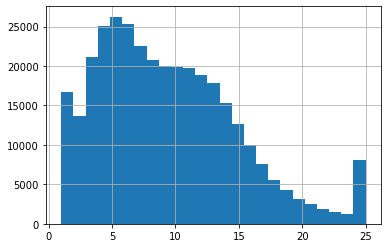

In [19]:
it['clean_lemma_title'].str.split().str.len().hist(bins=25)

it to csv

In [65]:
q = it[['sys_numb','ff_year_izd','ff_author','ff_izd','lang','clean_lemma_title']]
q.columns = ['item_id:token','ff_year_izd:token','ff_author:token','ff_izd:token','lang:token','clean_lemma_title:token_seq']
q.to_csv(dir_data+'bib.item', index=False, sep='\t')
q[:2]

,item_id:token,ff_year_izd:token,ff_author:token,ff_izd:token,lang:token,clean_lemma_title:token_seq
0,RSL01008600016,f1:2015,f2:av_,f3:izd4,ru,судебный следствие уголовный процесс росс...
1,RSL01004304880,f1:2005,f2:av_,f3:izd0,ru,уральский казачество его роль система рос...


us to csv

In [23]:
merge_df[:2]

,chb,sys_numb,title,author,izd,year_izd,ff_year_izd,clean_lemma_title,clean_no_lemma_title,age,gender,chit_type,ff_age,ff_gender,ff_chit_type
2,100000641403,RSL01000769304,"Медицинская, научная и общественная деяте...",шалаев николай федорович,ноизд,1993,f1:1970,медицинский научный общественный деятельн...,медицинская научная и общественная деятел...,55,m,no,f1:40,f2:m,f3:no
0,100000641403,RSL01004206702,Придание огнестойкости деревянным построй...,максимов владимир лаврович,гл упр землеустройства и земледелия,1915,f1:1900,придание огнестойкость деревянный постройка,придание огнестойкости деревянным постройкам,55,m,no,f1:40,f2:m,f3:no


<AxesSubplot:>

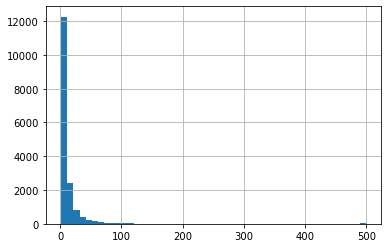

In [31]:
merge_df.groupby('chb')['sys_numb'].nunique().hist(bins=50)

<AxesSubplot:>

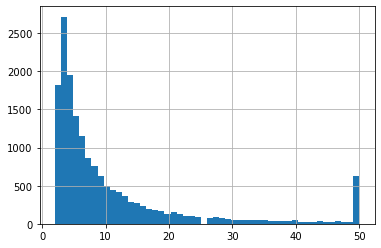

In [41]:
user_count = merge_df.groupby('chb')['sys_numb'].nunique()
user_count.loc[user_count>50] = 50
user_count.hist(bins=50)

In [52]:
us['chb']

0        300001020830
1        300001113642
2        300001148466
3        300001117011
4        200001038094
             ...     
16748    300001154270
16749    200000851690
16750    200001154993
16751    200001155169
16752    300001155049
Name: chb, Length: 16753, dtype: int64

In [60]:
user_count = merge_df.groupby('chb')['sys_numb'].nunique()
def count_book(x):
        if x > 50:
            return '50'
        elif x > 20:
            return '20'
        elif x > 7:
            return '7'
        else:
            return '3'
user_count = user_count.apply(count_book).to_frame()
user_count.columns = ['read_counts']
user_count = user_count.reindex(us['chb']).reset_index(drop=True)
user_count

,read_counts
0,20
1,20
2,20
3,3
4,7
...,...
16748,3
16749,3
16750,3
16751,3


In [62]:
us['ff_read_counts'] = user_count['read_counts']
us[:2]

,chb,age,gender,chit_type,ff_age,ff_gender,ff_chit_type,read_counts,ff_read_counts
0,300001020830,21,f,no,f1:17,f2:f,f3:no,20,20
1,300001113642,36,f,no,f1:30,f2:f,f3:no,20,20


In [64]:
q = us[['chb','ff_age','ff_gender','ff_chit_type','ff_read_counts']]
q.columns = ['user_id:token','ff_age:token','ff_gender:token','ff_chit_type:token','ff_read_counts:token']
q.to_csv(dir_data+'bib.user', index=False, sep='\t')
q[:2]

,user_id:token,ff_age:token,ff_gender:token,ff_chit_type:token,ff_read_counts:token
0,300001020830,f1:17,f2:f,f3:no,20
1,300001113642,f1:30,f2:f,f3:no,20


df to csv

In [66]:
df[:2]

,chb,sys_numb,date_1,is_real,type,source,is_printed,time_inv_rank
0,100000641403,RSL01004206702,2021-02-21,yes,скачивание,dlib.rsl.ru,False,2.000
2,100000641403,RSL01004211574,2021-02-21,yes,скачивание,dlib.rsl.ru,False,3.000


In [71]:
df['timestamp']=df['date_1'].astype(np.int64) // 10 ** 9
df[:2]

,chb,sys_numb,date_1,is_real,type,source,is_printed,time_inv_rank,timestamp
0,100000641403,RSL01004206702,2021-02-21,yes,скачивание,dlib.rsl.ru,False,2.000,1613865600
2,100000641403,RSL01004211574,2021-02-21,yes,скачивание,dlib.rsl.ru,False,3.000,1613865600


In [72]:
df = df[['chb','sys_numb','is_printed','timestamp']]
df.columns = ['user_id:token','item_id:token','is_printed:token','timestamp:float']
df.to_csv(dir_data+'bib.inter', index=False, sep='\t')
df[:2]

,user_id:token,item_id:token,is_printed:token,timestamp:float
0,100000641403,RSL01004206702,False,1613865600
2,100000641403,RSL01004211574,False,1613865600
